In [1]:
from tqdm import tqdm
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz


In [5]:
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'm

In [7]:
print(type(x_train[0]))
print(x_train[0].shape)

<class 'numpy.ndarray'>
(28, 28)


In [8]:
from PIL import Image

In [9]:
for i, image_array in enumerate(x_train):
    imgjpg = Image.fromarray(image_array, 'L')  # Convert to grayscale
    imgjpg.save(f'images/training/img{i}.jpg')  # Save with unique filename

In [10]:
for i, image_array in enumerate(x_test):
    imgjpg = Image.fromarray(image_array, 'L')  # Convert to grayscale
    imgjpg.save(f'images/testing/img{i}.jpg')  # Save with unique filename

In [11]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [12]:
import cv2
import math
import os


In [13]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

2024-01-25 14:08:29.736785: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 14:08:29.763021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 14:08:29.763045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 14:08:29.763749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 14:08:29.768649: I tensorflow/core/platform/cpu_feature_guar

In [14]:
# Create options for Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True #@param {type:"boolean"}
quantize = True #@param {type:"boolean"}
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

In [15]:
# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:
    # Get the list of image files in your folder
    image_files = os.listdir('images/training')
    # Create an empty list to store the embeddings
    embeddings = []
    # Loop over the image files
    for image_file in image_files:
        # Format images for MediaPipe
        image_i = mp.Image.create_from_file('images/training/' + image_file)
        # Embed the image
        embedding_i = embedder.embed(image_i)
        # Append the embedding to the list
        embeddings.append(embedding_i)
    # Convert the list to a numpy array
    x_train_embeddings = np.array(embeddings)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:
    # Get the list of image files in your folder
    image_files = os.listdir('images/testing')
    # Create an empty list to store the embeddings
    embeddings = []
    # Loop over the image files
    for image_file in image_files:
        # Format images for MediaPipe
        image_i = mp.Image.create_from_file('images/testing/' + image_file)
        # Embed the image
        embedding_i = embedder.embed(image_i)
        # Append the embedding to the list
        embeddings.append(embedding_i)
    # Convert the list to a numpy array
    x_test_embeddings = np.array(embeddings)

In [17]:
for i, e in enumerate(x_train_embeddings[10].embeddings):
    print(e.embedding)
    arr = np.array(e.embedding)
    print("dimension of embedding vector: ", len(arr))

[  2   1   1 ...   0   4 255]
dimension of embedding vector:  1024


In [18]:
embeddings_train_list = [] # create an empty list to store the embedding arrays
for j, ee in enumerate(x_train_embeddings):
    for i, e in enumerate(x_train_embeddings[j].embeddings):    
        arr = np.array(e.embedding) # convert the embedding attribute to a numpy array
        embeddings_train_list.append(arr) # append the array to the list
training_embeddings_array = np.stack(embeddings_train_list, axis=0)

In [19]:
print(training_embeddings_array.shape)

(546, 1024)


In [20]:
embeddings_test_list = [] # create an empty list to store the embedding arrays
for j, ee in enumerate(x_test_embeddings):
    for i, e in enumerate(x_test_embeddings[j].embeddings):    
        arr = np.array(e.embedding) # convert the embedding attribute to a numpy array
        embeddings_test_list.append(arr) # append the array to the list
testing_embeddings_array = np.stack(embeddings_test_list, axis=0)

In [21]:
print(testing_embeddings_array.shape)

(156, 1024)


In [22]:
X_train = training_embeddings_array
X_test = testing_embeddings_array

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(546, 1024)
(156, 1024)
(546, 1)
(156, 1)


In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# create an instance of the MinMaxScaler class with the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# fit the scaler on the training dataset
scaler.fit(X_train)

# transform the training and test datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

num_features = 1024
selector = SelectKBest(f_classif, k=num_features)
X_train_new = selector.fit_transform(X_train, y_train.ravel())

# Transform both training and test data
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

print("New shape of training data: ", X_train_new.shape)
print("New shape of test data: ", X_test_new.shape)

New shape of training data:  (546, 1024)
New shape of test data:  (156, 1024)


/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [707] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [27]:
X_train = X_train_new
X_test = X_test_new

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(546, 1024)
(156, 1024)
(546, 1)
(156, 1)


In [30]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [31]:
# Run a binary SVC classifier
# Create and fit the model

# Define the parameter ranges
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': ['scale', 'auto',100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.727 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.725 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.618 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.560 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.651 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.606 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.587 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.727 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [32]:
# Print the best parameters
print(grid.best_params_)

# Predict the test set results
grid_predictions = grid.predict(X_test)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [33]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, grid_predictions)

print(f"Accuracy: {accuracy * 100}%")

Accuracy: 73.07692307692307%


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.73      1.00      0.84       114

    accuracy                           0.73       156
   macro avg       0.37      0.50      0.42       156
weighted avg       0.53      0.73      0.62       156



/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


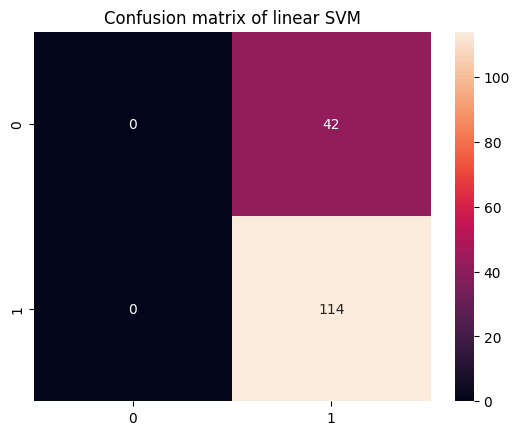

In [34]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,grid_predictions))

In [ ]:
clf = grid.best_estimator_
clf.get_params()
print(clf.n_support_)

In [ ]:
# get the actual output of SVM
decision_function = clf.decision_function(X_test)
print(decision_function)

In [ ]:
import numpy as np
print("svc.gamma: ", clf._gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"
gammaValue="../data-kernel-model-rbf/gamma.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in X_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
with open(gammaValue, "w") as f4:
    f4.write(str(clf._gamma))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()
f4.close()

In [ ]:
print(str(clf._gamma))
print(str(clf.intercept_))

In [ ]:
print(clf.support_vectors_[0].shape)